# Simple Neural Network(MLP) Implementation from Scratch

* This notebook demonstrates a basic implementation of a neural network(**MLP**) from scratch using Python and NumPy.
* It also implemented regularization technique like **L-2** and **Dropout** to handle overfiting problem.

* **CIFAR-10** , **Pima Indians Diabetes dataset** and **Breast Cancer** like dataset is used to evaluate the model(**neural network**) performance.


<a name='1'></a>
## 1 - Packages

In [ ]:
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix

In [ ]:
# Attempt to import CuPy for GPU acceleration, otherwise use NumPy
try:
    import cupy as np
    # test if a GPU is actually visible
    _ = np.zeros((1,))  # will fail if no CUDA device
    USE_GPU = True
    print("✅ Using CuPy (GPU)")
except Exception:
    import numpy as np
    USE_GPU = False
    print("⚠️ Using NumPy (CPU)")

✅ Using CuPy (GPU)


<a name='1-1'></a>
## 1.1 - Decorator for cupy -> numpy array

In [ ]:
def numpy_safe(fn):
    """
    Decorator to ensure that inputs to a function are NumPy arrays.
    This is useful when working with CuPy and functions that expect NumPy input.
    """
    def to_numpy(x):
      """Convert CuPy array → NumPy array, leave NumPy array unchanged."""
      if hasattr(x, "get"):   # CuPy arrays have .get()
          return x.get()
      return x

    def wrapper(*args, **kwargs):
        args = [to_numpy(a) for a in args]
        kwargs = {k: to_numpy(v) for k, v in kwargs.items()}
        return fn(*args, **kwargs)
    return wrapper

accuracy_score_safe = numpy_safe(accuracy_score)

In [ ]:
def plot_safe(fn):
    # Decorator to convert 0-dimensional NumPy/CuPy arrays to Python scalars.
    def wrapper(*args, **kwargs):
        result = fn(*args, **kwargs)

        # If result is a numpy/cupy scalar (0-d array), convert to Python float
        if hasattr(result, "item") and callable(result.item):
            return result.item()

        return result
    return wrapper

<a name='2'></a>
## 2 - Parameter Initialization

There are two types of parameters to initialize in a neural network:
- the weight matrices $(W^{[1]}, W^{[2]}, W^{[3]}, ..., W^{[L-1]}, W^{[L]})$
- the bias vectors $(b^{[1]}, b^{[2]}, b^{[3]}, ..., b^{[L-1]}, b^{[L]})$

In [ ]:
def initialize_parameters(layers, activations='tanh'):
  """
  Initializes the parameters (weights and biases) for a neural network.

  Arguments:
  layers -- a list containing the number of nodes in each layer (including the input layer)

  Returns:
  parameters -- a dictionary containing the initialized parameters
                ("W1", "b1", ..., "WL", "bL")
  """
  parameters = {}
  L = len(layers)  # Number of layers in the network

  for l in range(1, L):
    # Initialize weights with small random values to break symmetry
    if activations == 'tanh':
      parameters[f"W{l}"] = np.random.randn(layers[l], layers[l-1]) * np.sqrt(1 / layers[l-1])
    elif activations == 'relu':
      parameters[f"W{l}"] = np.random.randn(layers[l], layers[l-1]) * np.sqrt(2 / layers[l-1])
    else:
      parameters[f"W{l}"] = np.random.randn(layers[l], layers[l-1]) * 0.01
    # Initialize biases as zeros
    parameters[f"b{l}"] = np.zeros((layers[l], 1))

  return parameters

In [ ]:
def initialize_velocity(parameters):
  """
  Initializes the velocity dictionary with zeros for momentum optimization.

  Arguments:
  parameters -- python dictionary containing your parameters ("W1", "b1", ..., "WL", "bL")

  Returns:
  v -- python dictionary that will store the velocities for each parameter
  """

  L = len(parameters) // 2  # Number of layers with W, b

  v = {}
  # Initialize velocities with zeros, same shape as parameters
  for l in range(1, L + 1):
    v[f"dW{l}"] = np.zeros_like(parameters[f"W{l}"])
    v[f"db{l}"] = np.zeros_like(parameters[f"b{l}"]) # Corrected key for bias velocity

  return v

In [ ]:
def initialize_adam(parameters):
  """
  Initializes the Adam optimization variables (first and second moment estimates) with zeros.

  Arguments:
  parameters -- python dictionary containing your parameters ("W1", "b1", ..., "WL", "bL")

  Returns:
  v -- python dictionary that will store the exponentially weighted average of past gradients (first moment)
  s -- python dictionary that will store the exponentially weighted average of the squares of past gradients (second moment)
  """

  L = len(parameters) // 2  # Number of layers with W, b

  v = {}
  s = {}
  # Initialize v and s with zeros, same shape as parameters
  for l in range(1, L + 1):
    v[f"dW{l}"] = np.zeros_like(parameters[f"W{l}"])
    v[f"db{l}"] = np.zeros_like(parameters[f"db{l}"])
    s[f"dW{l}"] = np.zeros_like(parameters[f"dW{l}"])
    s[f"db{l}"] = np.zeros_like(parameters[f"db{l}"])

  return v, s

<a name='3'></a>
## 3 - Activation Methods & Its Derivative

<a name='3-1'></a>
## 3.1 - Sigmoid Activation Method

In [ ]:
def sigmoid(x):
  """
  Computes the sigmoid activation function.

  Arguments:
  x -- input value or array

  Returns:
  sigmoid(x) -- the output of the sigmoid function
  """
  x = np.clip(x, -500, 500)
  return 1 / (1 + np.exp(-x))

In [ ]:
def sigmoid_derivative(A):
  """
  Computes the derivative of the sigmoid function.

  Arguments:
  A -- the output of the sigmoid function (post-activation value)

  Returns:
  dA -- gradient of the sigmoid function
  """
  # The derivative of sigmoid(x) is sigmoid(x) * (1 - sigmoid(x))
  # If A is the output of sigmoid(x), then the derivative is A * (1 - A)
  dA = A * (1 - A)
  return dA

<a name='3-2'></a>
## 3.2 - Relu Activation Method

In [ ]:
def relu(x):
  """
  Computes the ReLU activation function.

  Arguments:
  x -- input value or array

  Returns:
  relu(x) -- the output of the ReLU function
  """
  return np.maximum(0, x)

In [ ]:
def relu_derivative(x):
  """
  Computes the derivative of the ReLU function.

  Arguments:
  x -- input to the ReLU function (pre-activation value Z)

  Returns:
  dx -- gradient of the ReLU function
  """
  # The derivative is 1 if x > 0, and 0 otherwise.
  # We can implement this by creating a matrix of the same shape as x
  # and setting values to 1 where x > 0 and 0 otherwise.
  dx = (x > 0).astype(float)
  return dx

<a name='3-3'></a>
## 3.3 - Tanh Activation Method

In [ ]:
def tanh_derivative(A):
  """
  Computes the derivative of the tanh function.

  Arguments:
  A -- the output of the tanh function (post-activation value)

  Returns:
  dA -- gradient of the tanh function
  """
  # The derivative of tanh(x) is 1 - tanh^2(x)
  # If A is the output of tanh(x), then the derivative is 1 - A^2
  dA = 1 - np.power(A, 2)
  return dA

<a name='4'></a>
## 4 - Forward Propagation

<a name='4-1'></a>
## 4.1 - Basic Forward Propagation

In [ ]:
def forward_propagation(parameters, X, activations = 'tanh'):
  """
  Implements forward propagation for the neural network.

  Arguments:
  parameters -- python dictionary containing your parameters ("W1", "b1", ..., "WL", "bL")
  X -- input data of shape (input size, number of examples)

  Returns:
  A_L -- the output of the neural network (after the last activation)
  cache -- a dictionary containing "Zl" and "Al" for each layer l
  """
  A = X
  cache = {}
  L = len(parameters) // 2  # number of layers in the neural network

  # Implement [LINEAR -> ACTIVATION FUNCTION] * (L-1)
  for l in range(1, L):
    W = parameters[f"W{l}"]
    b = parameters[f"b{l}"]

    Z = np.dot(W, A) + b
    if activations == 'relu':
      A = np.maximum(0, Z)  # Using ReLU activation for hidden layers
    elif activations == 'tanh':
      A = np.tanh(Z)
    cache[f"Z{l}"] = Z
    cache[f"A{l}"] = A

  # Implement LINEAR -> SIGMOID for the output layer
  W_L = parameters[f"W{L}"]
  b_L = parameters[f"b{L}"]
  Z_L = np.dot(W_L, A) + b_L
  A_L = sigmoid(Z_L)

  cache[f"Z{L}"] = Z_L
  cache[f"A{L}"] = A_L

  return A_L, cache

<a name='4-2'></a>
## 4.2 - Forward Propagation With dropout


In [ ]:
def forward_propagation_with_dropout(parameters, X, keep_prob, activations = 'tanh'):
  """
  Implements forward propagation for the neural network with dropout.

  Arguments:
  parameters -- python dictionary containing your parameters ("W1", "b1", ..., "WL", "bL")
  X -- input data of shape (input size, number of examples)
  keep_prob -- dropout probability (percentage of neurons to keep)

  Returns:
  A_L -- the output of the neural network (after the last activation)
  cache -- a dictionary containing "Zl", "Al", and "Dl" for each layer l
  """
  A = X
  cache = {}
  L = len(parameters) // 2  # number of layers in the neural network

  # Implement [LINEAR -> ACTIVATION -> DROPOUT] * (L-1)
  for l in range(1, L):
    W = parameters[f"W{l}"]
    b = parameters[f"b{l}"]
    Z = np.dot(W, A) + b
    if activations == 'relu':
      A = np.maximum(0, Z)  # Using ReLU activation for hidden layers
    elif activations == 'tanh':
      A = np.tanh(Z)

    # Implement Dropout
    D = np.random.rand(A.shape[0], A.shape[1]) < keep_prob
    A = A * D
    A = A / keep_prob # Scale the activations

    cache[f"Z{l}"] = Z
    cache[f"A{l}"] = A
    cache[f"D{l}"] = D # Store the dropout mask

  # Implement LINEAR -> SIGMOID for the output layer
  W_L = parameters[f"W{L}"]
  b_L = parameters[f"b{L}"]
  Z_L = np.dot(W_L, A) + b_L
  A_L = sigmoid(Z_L)  # Using sigmoid activation for the output layer

  cache[f"Z{L}"] = Z_L
  cache[f"A{L}"] = A_L

  return A_L, cache

<a name='5'></a>
## 5 - Compute Cost Step

<a name='4-1'></a>
## 5.1 - Compute Cost

In [ ]:
@plot_safe
def compute_cost(A, Y):
  """
  Computes the cross-entropy cost function.

  Arguments:
  A -- the output of the neural network (after the last activation)
  Y -- the true labels

  Returns:
  cost -- the cross-entropy cost
  """
  m = Y.shape[1]  # Number of examples
  epsilon = 1e-8
  # Compute the cross-entropy cost
  cost = -1/m * np.sum(Y * np.log(A + epsilon) + (1 - Y) * np.log(1 - A + epsilon))

  return cost

<a name='5-2'></a>
## 5.2 - Compute Cost With Regularisation

In [ ]:
@plot_safe
def compute_cost_with_regularization(A, Y, parameters, lambd = 0.1):
  """
  Computes the cross-entropy cost function with L2 regularization.

  Arguments:
  A -- the output of the neural network (after the last activation)
  Y -- the true labels
  parameters -- python dictionary containing your parameters ("W1", "b1", ..., "WL", "bL")
  lambd -- the regularization hyperparameter

  Returns:
  cost -- the cross-entropy cost with L2 regularization
  """
  m = Y.shape[1]  # Number of examples
  epsilon = 1e-8
  # Compute the cross-entropy cost (same as before)
  cross_entropy_cost = -1/m * np.sum(Y * np.log(A + epsilon) + (1 - Y) * np.log(1 - A + epsilon))

  # Compute the L2 regularization term
  L = len(parameters) // 2 # number of layers
  L2_regularization_cost = 0
  for l in range(1, L + 1):
    L2_regularization_cost += np.sum(np.square(parameters[f"W{l}"]))

  L2_regularization_cost = (lambd / (2 * m)) * L2_regularization_cost

  # Total cost is the sum of cross-entropy cost and L2 regularization cost
  cost = cross_entropy_cost + L2_regularization_cost

  return cost

<a name='6'></a>
## 6 - Backward Propagation

<a name='5-1'></a>
## 6.1 - Basic Backward Propagation

In [ ]:
def backward_propagate(parameters, cache, X, Y, activations = 'tanh'):
  """
  Implements backward propagation for the neural network.

  Arguments:
  parameters -- python dictionary containing your parameters ("W1", "b1", ..., "WL", "bL")
  cache -- a dictionary containing "Zl" and "Al" for each layer l
  X -- input data of shape (input size, number of examples)
  Y -- true labels vector of shape (output size, number of examples)

  Returns:
  grads -- a dictionary with the gradients with respect to each parameter, same keys as parameters
  """
  L = len(parameters) // 2  # number of layers
  m = X.shape[1]
  grads = {}

  # Derivative of the cost function
  dAL = - (np.divide(Y, cache[f"A{L}"]) - np.divide(1 - Y, 1 - cache[f"A{L}"]))

  # Backpropagate through the output layer (SIGMOID activation)
  dZL = dAL * sigmoid_derivative(cache[f"A{L}"]) # Derivative of sigmoid
  grads[f"dW{L}"] = 1/m * np.dot(dZL, cache[f"A{L-1}"].T)
  grads[f"db{L}"] = 1/m * np.sum(dZL, axis=1, keepdims=True)
  dAPrev = np.dot(parameters[f"W{L}"].T, dZL)

  # Backpropagate through the hidden layers
  for l in reversed(range(1, L)):
    if activations == 'relu':
      dZL = dAPrev * relu_derivative(cache[f"A{l}"])
    elif activations == 'tanh':
      dZL = dAPrev * tanh_derivative(cache[f"A{l}"])
    grads[f"dW{l}"] = 1/m * np.dot(dZL, cache[f"A{l-1}"].T if l > 1 else X.T)
    grads[f"db{l}"] = 1/m * np.sum(dZL, axis=1, keepdims=True)
    if l > 1:
      dAPrev = np.dot(parameters[f"W{l}"].T, dZL)

  return grads

<a name='6-2'></a>
## 6.2 - Backward Propagation With L2 Regularisation

In [ ]:
def backward_propagate_with_regularization(parameters, cache, X, Y, lambd = 0.1, activations = 'tanh'):
  """
  Implements backward propagation for the neural network with L2 regularization.

  Arguments:
  parameters -- python dictionary containing your parameters ("W1", "b1", ..., "WL", "bL")
  cache -- a dictionary containing "Zl" and "Al" for each layer l
  X -- input data of shape (input size, number of examples)
  Y -- true labels vector of shape (output size, number of examples)
  lambd -- the regularization hyperparameter

  Returns:
  grads -- a dictionary with the gradients with respect to each parameter, same keys as parameters
  """
  L = len(parameters) // 2  # number of layers
  m = X.shape[1]
  grads = {}

  # Derivative of the sigmoid cost function
  dAL = - (np.divide(Y, cache[f"A{L}"]) - np.divide(1 - Y, 1 - cache[f"A{L}"]))

  # Backpropagate through the output layer (SIGMOID activation)
  #dZL = dAL * (cache[f"A{L}"] * (1 - cache[f"A{L}"])) # Derivative of sigmoid
  dZL = dAL * sigmoid_derivative(cache[f"A{L}"]) # Derivative of sigmoid
  # Add L2 regularization gradient to dWL
  grads[f"dW{L}"] = 1/m * np.dot(dZL, cache[f"A{L-1}"].T) + (lambd / m) * parameters[f"W{L}"]
  grads[f"db{L}"] = 1/m * np.sum(dZL, axis=1, keepdims=True)
  dAPrev = np.dot(parameters[f"W{L}"].T, dZL)

  # Backpropagate through the hidden layers (TANH activation)
  for l in reversed(range(1, L)):
    # dZL = dAPrev * (1 - np.power(cache[f"A{l}"], 2)) # Derivative of tanh
    # Add L2 regularization gradient to dWl
    if activations == 'relu':
      dZL = dAPrev * relu_derivative(cache[f"A{l}"])
    elif activations == 'tanh':
      dZL = dAPrev * tanh_derivative(cache[f"A{l}"])
    grads[f"dW{l}"] = 1/m * np.dot(dZL, cache[f"A{l-1}"].T if l > 1 else X.T) + (lambd / m) * parameters[f"W{l}"]
    grads[f"db{l}"] = 1/m * np.sum(dZL, axis=1, keepdims=True)
    if l > 1:
      dAPrev = np.dot(parameters[f"W{l}"].T, dZL)

  return grads

<a name='6-3'></a>
## 6.3 - Backward Propagation With Dropout

In [ ]:
def backward_propagate_with_dropout(parameters, cache, X, Y, keep_prob=0.8, activations = 'tanh'):
  """
  Implements backward propagation for the neural network with dropout.

  Arguments:
  parameters -- python dictionary containing your parameters ("W1", "b1", ..., "WL", "bL")
  cache -- a dictionary containing "Zl", "Al", and "Dl" for each layer l
  X -- input data of shape (input size, number of examples)
  Y -- true labels vector of shape (output size, number of examples)
  keep_prob -- dropout probability (percentage of neurons to keep)

  Returns:
  grads -- a dictionary with the gradients with respect to each parameter, same keys as parameters
  """
  L = len(parameters) // 2  # number of layers
  m = X.shape[1]
  grads = {}

  # Derivative of the sigmoid cost function
  dAL = - (np.divide(Y, cache[f"A{L}"]) - np.divide(1 - Y, 1 - cache[f"A{L}"]))

  # Backpropagate through the output layer (SIGMOID activation)
  dZL = dAL * sigmoid_derivative(cache[f"A{L}"]) # Derivative of sigmoid
  grads[f"dW{L}"] = 1/m * np.dot(dZL, cache[f"A{L-1}"].T)
  grads[f"db{L}"] = 1/m * np.sum(dZL, axis=1, keepdims=True)
  dAPrev = np.dot(parameters[f"W{L}"].T, dZL)

  # Backpropagate through the hidden layers
  for l in reversed(range(1, L)):
    # Apply dropout mask to dAPrev
    dAPrev = dAPrev * cache[f"D{l}"]
    dAPrev = dAPrev / keep_prob # Scale the gradients

    if activations == 'relu':
      dZL = dAPrev * relu_derivative(cache[f"A{l}"])
    elif activations == 'tanh':
      dZL = dAPrev * tanh_derivative(cache[f"A{l}"])
    grads[f"dW{l}"] = 1/m * np.dot(dZL, cache[f"A{l-1}"].T if l > 1 else X.T)
    grads[f"db{l}"] = 1/m * np.sum(dZL, axis=1, keepdims=True)
    if l > 1:
      dAPrev = np.dot(parameters[f"W{l}"].T, dZL)

  return grads

<a name='7'></a>
## 7 - Update parameter

<a name='7-1'></a>
## 7.1 - Vanilla GD

In [ ]:
def update_parameters(parameters, grads, learning_rate):
  """
  Updates the parameters (weights and biases) using gradient descent.

  Arguments:
  parameters -- python dictionary containing your parameters ("W1", "b1", ..., "WL", "bL")
  grads -- python dictionary containing your gradients ("dW1", "db1", ..., "dWL", "dbL")
  learning_rate -- the learning rate for gradient descent

  Returns:
  parameters_updated -- python dictionary containing the updated parameters
  """
  print(f"grads parameters: {grads.keys()}")
  parameters_updated = {}
  L = len(parameters) // 2  # number of layers in the neural network

  # Update rule for each parameter (weight and bias)
  for l in range(1, L + 1):
    parameters_updated[f"W{l}"] = parameters[f"W{l}"] - learning_rate * grads[f"dW{l}"]
    parameters_updated[f"b{l}"] = parameters[f"b{l}"] - learning_rate * grads[f"db{l}"]

  return parameters_updated

<a name='7-2'></a>
## 7.2 - Momentum

In [ ]:
def update_parameters_with_momentum(parameters, grads, v, learning_rate=0.001, beta=0.9):
  """
  Updates the parameters using the momentum optimization algorithm.

  Arguments:
  parameters -- python dictionary containing your parameters ("W1", "b1", ..., "WL", "bL")
  grads -- python dictionary containing your gradients ("dW1", "db1", ..., "dWL", "dbL")
  v -- python dictionary containing the velocities for each parameter
  learning_rate -- the learning rate for gradient descent
  beta -- the momentum coefficient

  Returns:
  parameters_updated -- python dictionary containing the updated parameters
  v_updated -- python dictionary containing the updated velocities
  """
  parameters_updated = {}
  v_updated = {}
  L = len(parameters) // 2  # number of layers in the neural network

  # Update rule for each parameter (weight and bias)
  for l in range(1, L + 1):
    # Compute updated velocity
    v_updated[f"dW{l}"] = beta * v[f"dW{l}"] + (1 - beta) * grads[f"dW{l}"]
    v_updated[f"db{l}"] = beta * v[f"db{l}"] + (1 - beta) * grads[f"db{l}"]

    parameters_updated[f"W{l}"] = parameters[f"W{l}"] - learning_rate * v_updated[f"dW{l}"]
    parameters_updated[f"b{l}"] = parameters[f"b{l}"] - learning_rate * v_updated[f"db{l}"]

  return parameters_updated, v_updated

<a name='7-3'></a>
## 7.3 - Adam

In [ ]:
# Improved Code for adam
def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate=0.001,
                                beta1=0.9, beta2=0.999, epsilon=1e-8):
    """
    Updates the parameters using the Adam optimization algorithm with optimized bias correction.

    Arguments:
    parameters -- python dictionary containing your parameters ("W1", "b1", ..., "WL", "bL")
    grads -- python dictionary containing your gradients ("dW1", "db1", ..., "dWL", "dbL")
    v -- Adam variable, moving average of the first moment of the gradient
    s -- Adam variable, moving average of the second moment of the squared gradient
    t -- Adam time step (iteration number)
    learning_rate -- the learning rate for gradient descent
    beta1 -- Exponential decay hyperparameter for the first moment estimates
    beta2 -- Exponential decay hyperparameter for the second moment estimates
    epsilon -- hyperparameter preventing division by zero in Adam updates

    Returns:
    parameters -- python dictionary containing the updated parameters
    v -- Adam variable, moving average of the first moment of the gradient
    s -- Adam variable, moving average of the second moment of the squared gradient
    """
    L = len(parameters) // 2

    # Precompute bias correction factors
    v_corrected_factor = 1 - np.power(beta1, t)
    s_corrected_factor = 1 - np.power(beta2, t)

    for l in range(1, L + 1):
        # Update biased first moment estimate
        v[f"dW{l}"] = beta1 * v[f"dW{l}"] + (1 - beta1) * grads[f"dW{l}"]
        v[f"db{l}"] = beta1 * v[f"db{l}"] + (1 - beta1) * grads[f"db{l}"]

        # Update biased second moment estimate
        s[f"dW{l}"] = beta2 * s[f"dW{l}"] + (1 - beta2) * np.square(grads[f"dW{l}"])
        s[f"db{l}"] = beta2 * s[f"db{l}"] + (1 - beta2) * np.square(grads[f"db{l}"])

        # Compute bias-corrected estimates
        v_corrected_dW = v[f"dW{l}"] / v_corrected_factor
        v_corrected_db = v[f"db{l}"] / v_corrected_factor
        s_corrected_dW = s[f"dW{l}"] / s_corrected_factor
        s_corrected_db = s[f"db{l}"] / s_corrected_factor

        # Update parameters
        parameters[f"W{l}"] -= learning_rate * v_corrected_dW / (np.sqrt(s_corrected_dW) + epsilon)
        parameters[f"b{l}"] -= learning_rate * v_corrected_db / (np.sqrt(s_corrected_db) + epsilon)

    return parameters, v, s

<a name='8'></a>
## 8 - Deep Neural Network

## Neural Network Helper Function

<a name='8-1'></a>
## 8.1 - Basic Neural Network

In [ ]:
def configure_network(layers, input_size, output_size):
  layers.insert(0, input_size)
  layers.append(output_size)
  return layers

In [ ]:
def NN_from_scratch(X, Y, layers,
                    learning_rate, iter=1000,
                    activations='tanh', optimizer='GD',
                    network_type='basic',
                    lambd=0.01, keep_prob=0.8):
  """
  Trains a simple neural network from scratch.

  Arguments:
  X -- input data of shape (input size, number of examples)
  Y -- true labels vector of shape (output size, number of examples)
  layers -- a list containing the number of nodes in each hidden layer (excluding input and output)
  learning_rate -- the learning rate for gradient descent
  iter -- number of iterations for training
  optimizer -- one of 'GD', 'momentum', or 'adam'
  network_type -- one of 'basic', 'L2', or 'dropout'
  lambd -- the regularization hyperparameter
  keep_prob -- dropout probability (percentage of neurons to keep)

  Returns:
  parameters -- the learned parameters after training
  costs -- a list containing the cost at each iteration
  """
  # Add Input and Output Size in the network
  layers = configure_network(layers, X.shape[0], Y.shape[0])

  # Initialize parameters for the neural network
  parameters = initialize_parameters(layers, activations)

  if optimizer == 'momentum':
    v = initialize_velocity(parameters)
  elif optimizer == 'adam':
    v, s = initialize_adam(parameters)

  # List to store costs for plotting
  costs = []

  # Training loop
  for i in range(iter + 1):
    # 1. Forward Propagation
    if network_type == 'dropout':
      A, cache = forward_propagation_with_dropout(parameters, X, keep_prob, activations)
    else:
      A, cache = forward_propagation(parameters, X, activations)

    # 2. Compute Cost
    if network_type == 'L2':
      cost = compute_cost_with_regularization(A, Y, parameters, lambd)
    else:
      cost = compute_cost(A, Y)

    costs.append(cost)

    # 3. Backward propagation to compute gradients
    if network_type == 'dropout':
      grads = backward_propagate_with_dropout(parameters, cache, X, Y, keep_prob, activations)
    elif network_type == 'L2':
      grads = backward_propagate_with_regularization(parameters, cache, X, Y, lambd, activations)
    else:
      grads = backward_propagate(parameters, cache, X, Y, activations)

    # 4. Update parameters using gradient descent
    if optimizer == 'GD':
      parameters = update_parameters(parameters, grads, learning_rate)
    elif optimizer == 'momentum':
      parameters, v = update_parameters_with_momentum(parameters, grads, v, learning_rate)
    else:
      parameters, v, s = update_parameters_with_adam(parameters, grads, v, s, t=i, learning_rate=learning_rate)

    # 5. Optional: Print cost every a few iterations to see the learning progress
    step = iter // 25
    if i % step == 0:
        print(f"Cost after iteration {i}: {cost}")

  return parameters, costs

<a name='8-2'></a>
## 8.2 - Neural Network with L2 regularisation

In [ ]:
def NN_from_scratch_with_regularization(X, Y, layers, learning_rate, lambd = 0.1, iter=1000, activations='tanh', optimizer = 'GD'):
  """
  Trains a simple neural network from scratch with L2 regularization.

  Arguments:
  X -- input data of shape (input size, number of examples)
  Y -- true labels vector of shape (output size, number of examples)
  layers -- a list containing the number of nodes in each hidden layer (excluding input and output)
  learning_rate -- the learning rate for gradient descent
  lambd -- the regularization hyperparameter
  iter -- number of iterations for training

  Returns:
  parameters -- the learned parameters after training
  costs -- a list containing the cost at each iteration
  """
  # Insert input layer size at the beginning of the layers list
  layers.insert(0, X.shape[0])
  layers.append(Y.shape[0])
  # Initialize parameters for the neural network
  parameters = initialize_parameters(layers)
  if optimizer == 'momentum':
    v = initialize_velocity(parameters)
  elif optimizer == 'adam':
    v, s = initialize_adam(parameters)

  # List to store costs for plotting
  costs = []

  # Training loop
  for i in range(iter + 1):
    # Forward propagation
    A, cache = forward_propagation(parameters, X, activations)
    # Compute cost with regularization
    cost = compute_cost_with_regularization(A, Y, parameters, lambd)

    if np.isnan(cost):
        print(f"Cost became NaN at iteration {i}. Stopping training.")
        print(f"A: {A}")
        print(f"Y: {Y}")
        break # Exit the training loop

    # Store the cost
    costs.append(cost)

    # Backward propagation to compute gradients with regularization
    grads = backward_propagate_with_regularization(parameters, cache, X, Y, lambd, activations)
    # Update parameters using gradient descent
    if optimizer == 'GD':
      parameters = update_parameters(parameters, grads, learning_rate)
    elif optimizer == 'momentum':
      parameters, v = update_parameters_with_momentum(parameters, grads, v, learning_rate)
    else:
      # Pass i + 1 as the time step to Adam
      parameters, v, s = update_parameters_with_adam(parameters, grads, v, s, t=i+1, learning_rate=learning_rate)

    # Optional: Print cost every a few iterations to see the learning progress
    step = iter // 25
    if i % step == 0:
        print(f"Cost after iteration {i}: {cost}")

  return parameters, costs

<a name='8-3'></a>
## 8.3 - Neural Network With Dropout regularisation

In [ ]:
def NN_from_scratch_with_dropout(X, Y, layers, learning_rate, keep_prob, iter=1000, activations='tanh', optimizer = 'GD'):
  """
  Trains a simple neural network from scratch with dropout.

  Arguments:
  X -- input data of shape (input size, number of examples)
  Y -- true labels vector of shape (output size, number of examples)
  layers -- a list containing the number of nodes in each hidden layer (excluding input and output)
  learning_rate -- the learning rate for gradient descent
  keep_prob -- dropout probability (percentage of neurons to keep)
  iter -- number of iterations for training

  Returns:
  parameters -- the learned parameters after training
  costs -- a list containing the cost at each iteration
  """
  # Insert input layer size at the beginning of the layers list
  layers.insert(0, X.shape[0])
  layers.append(Y.shape[0])
  # Initialize parameters for the neural network
  parameters = initialize_parameters(layers)
  if optimizer == 'momentum':
    v = initialize_velocity(parameters)
  elif optimizer == 'adam':
    v, s = initialize_adam(parameters)

  # List to store costs for plotting
  costs = []

  # Training loop
  for i in range(iter + 1):
    # Forward propagation with dropout
    A, cache = forward_propagation_with_dropout(parameters, X, keep_prob, activations)
    # Compute cost (using the standard compute_cost as dropout is applied during forward/backward)
    cost = compute_cost(A, Y)

    # Store the cost
    costs.append(cost)

    # Backward propagation with dropout
    grads = backward_propagate_with_dropout(parameters, cache, X, Y, keep_prob, activations)
    # Update parameters using gradient descent
    if optimizer == 'GD':
      parameters = update_parameters(parameters, grads, learning_rate)
    elif optimizer == 'momentum':
      parameters, v = update_parameters_with_momentum(parameters, grads, v, learning_rate)
    else:
      parameters, v, s = update_parameters_with_adam(parameters, grads, v, s, t=i, learning_rate=learning_rate)

    # Optional: Print cost every a few iterations to see the learning progress
    step = iter // 25
    if i % step == 0:
        print(f"Cost after iteration {i}: {cost}")

  return parameters, costs

<a name='9'></a>
## 9 - NN Model Training and Testing

<a name='9-1'></a>
## 9.1 - Breast Cancer Dataset

<a name='9-1-1'></a>
### 9.1.1 - Load and Preprocess Data

In [ ]:
# 1. Load the data
breast_cancer = load_breast_cancer()
X = breast_cancer.data
Y = breast_cancer.target.reshape(1, -1) # Reshape Y to be (1, number_of_examples)

print(f"X shape: {X.shape}")
print(f"Y shape: {Y.shape}")

X shape: (569, 30)
Y shape: (1, 569)


In [ ]:
# 2. Preprocess the data (scaling the features)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X).T # Transpose X to be (input_size, number_of_examples)

# 3. Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled.T, Y.T, test_size=0.2, random_state=42)

# Transpose back to the required shape for the neural network functions
X_train = X_train.T
X_test = X_test.T
Y_train = Y_train.T
Y_test = Y_test.T

if USE_GPU:
  # NumPy → CuPy
  X_train = np.asarray(X_train)
  Y_train = np.asarray(Y_train)
  X_test = np.asarray(X_test)
  Y_test = np.asarray(Y_test)

print(f"X_type = {type(X_train), type(X_test)}")
print(f"Y_type = {type(Y_train), type(Y_test)}")

print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")

X_type = (<class 'cupy.ndarray'>, <class 'cupy.ndarray'>)
Y_type = (<class 'cupy.ndarray'>, <class 'cupy.ndarray'>)
X_train shape: (30, 455)
Y_train shape: (1, 455)
X_test shape: (30, 114)
Y_test shape: (1, 114)


<a name='9-1-2'></a>
### 9.1.2 - Model Performance

In [ ]:
# Train the neural network
# Define the network architecture (input layer size is added within the function)
layers_config = [8, 4, 2] # Example: three hidden layers
learning_rate = 0.1
iterations = 50000

parameters, costs = NN_from_scratch(X_train, Y_train, layers_config, learning_rate, iter=iterations, activations = 'tanh')

# Make predictions on the train test set
A_train, _ = forward_propagation(parameters, X_train)
predictions_train = (A_train > 0.5).astype(int)

A_test, _ = forward_propagation(parameters, X_test)
predictions_test = (A_test > 0.5).astype(int)


Cost after iteration 0: 0.7251031112510525
Cost after iteration 2000: 0.016694370854375383
Cost after iteration 4000: 0.01570766203001097
Cost after iteration 6000: 0.015386393070706699
Cost after iteration 8000: 0.015212833056343474
Cost after iteration 10000: 0.01510348274102359
Cost after iteration 12000: 0.015028471386823072
Cost after iteration 14000: 0.014973903744018137
Cost after iteration 16000: 0.014932455125553266
Cost after iteration 18000: 0.014899915347705087
Cost after iteration 20000: 0.014873697432708019
Cost after iteration 22000: 0.014852125640287143
Cost after iteration 24000: 0.014834067309601127
Cost after iteration 26000: 0.014818729614844673
Cost after iteration 28000: 0.014805541140522387
Cost after iteration 30000: 0.01479407970164053
Cost after iteration 32000: 0.014784026643889598
Cost after iteration 34000: 0.014775136950862909
Cost after iteration 36000: 0.014767219130744866
Cost after iteration 38000: 0.01476012134415128
Cost after iteration 40000: 0.0147

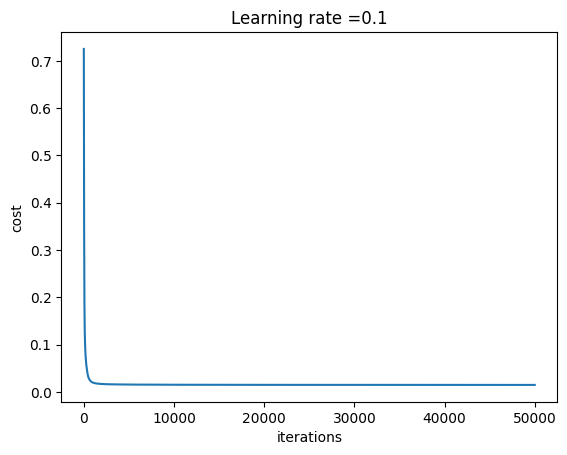


Accuracy on the train set: 0.9978

Accuracy on the test set: 0.9649


In [ ]:
# Evaluate the network's performance
# Convert CuPy arrays to NumPy arrays before passing to accuracy_score
accuracy_train = accuracy_score_safe(Y_train.T, predictions_train.T) # Transpose back for accuracy_score
accuracy_test = accuracy_score_safe(Y_test.T, predictions_test.T) # Transpose back for accuracy_score

plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations')
plt.title("Learning rate =" + str(learning_rate))
plt.show()

print(f"\nAccuracy on the train set: {accuracy_train:.4f}")
print(f"\nAccuracy on the test set: {accuracy_test:.4f}")

<a name='9-2'></a>
## 9.2 - Pima Indians Diabetes


<a name='9-2-1'></a>
### 9.2.1 - Load and Preprocess Data

In [ ]:
# Load the Pima Indians Diabetes dataset from a URL
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
names = ['pregnancies', 'glucose', 'blood_pressure', 'skin_thickness', 'insulin', 'bmi', 'pedigree_function', 'age', 'outcome']
dataframe = pd.read_csv(url, names=names)

# Separate features (X) and target (Y)
X = dataframe.drop('outcome', axis=1).values
Y = dataframe['outcome'].values.reshape(1, -1) # Reshape Y to be (1, number_of_examples)

# Preprocess the data (scaling the features)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X).T # Transpose X to be (input_size, number_of_examples)

# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled.T, Y.T, test_size=0.2, random_state=42)

# Transpose back to the required shape for the neural network functions
X_train = X_train.T
X_test = X_test.T
Y_train = Y_train.T
Y_test = Y_test.T

if USE_GPU:
  # NumPy → CuPy
  X_train = np.asarray(X_train)
  Y_train = np.asarray(Y_train)
  X_test = np.asarray(X_test)
  Y_test = np.asarray(Y_test)

print(f"X_type = {type(X_train), type(X_test)}")
print(f"Y_type = {type(Y_train), type(Y_test)}")

print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")


X_type = (<class 'cupy.ndarray'>, <class 'cupy.ndarray'>)
Y_type = (<class 'cupy.ndarray'>, <class 'cupy.ndarray'>)
X_train shape: (8, 614)
Y_train shape: (1, 614)
X_test shape: (8, 154)
Y_test shape: (1, 154)


<a name='9-2-2'></a>
### 9.2.2 - Model Performance

In [ ]:
layers_config = [10] # Example: one hidden layers
learning_rate = 0.1 # You might need to tune this learning rate
iterations = 50000 # You might need to adjust the number of iterations
lambd = 10 # Regularization hyperparameter

#### Basic Model Performance

In [ ]:
# Train the neural network
parameters, costs = NN_from_scratch(X_train, Y_train, layers_config, learning_rate, iter=iterations,activations = 'tanh')

# Make predictions on the test set
A_train, _ = forward_propagation(parameters, X_train)
predictions_train = (A_train > 0.5).astype(int)
A_test, _ = forward_propagation(parameters, X_test)
predictions_test = (A_test > 0.5).astype(int)


Cost after iteration 0: 0.7883655833838366
Cost after iteration 2000: 0.40202988386807914
Cost after iteration 4000: 0.37067225036196805
Cost after iteration 6000: 0.34523438343062185
Cost after iteration 8000: 0.31788184465639074
Cost after iteration 10000: 0.30145031529347316
Cost after iteration 12000: 0.2909212682648946
Cost after iteration 14000: 0.2807534650248743
Cost after iteration 16000: 0.27256474039102424
Cost after iteration 18000: 0.26488639373196804
Cost after iteration 20000: 0.2602353827236676
Cost after iteration 22000: 0.2571024500512868
Cost after iteration 24000: 0.25458029784293384
Cost after iteration 26000: 0.2523426523910923
Cost after iteration 28000: 0.25001888022754476
Cost after iteration 30000: 0.24759155451659112
Cost after iteration 32000: 0.24532103454041243
Cost after iteration 34000: 0.24325577802359113
Cost after iteration 36000: 0.2414920231759192
Cost after iteration 38000: 0.23997842844010253
Cost after iteration 40000: 0.2386660292406796
Cost aft


Accuracy on the train set: 0.9055

Accuracy on the test set: 0.7208


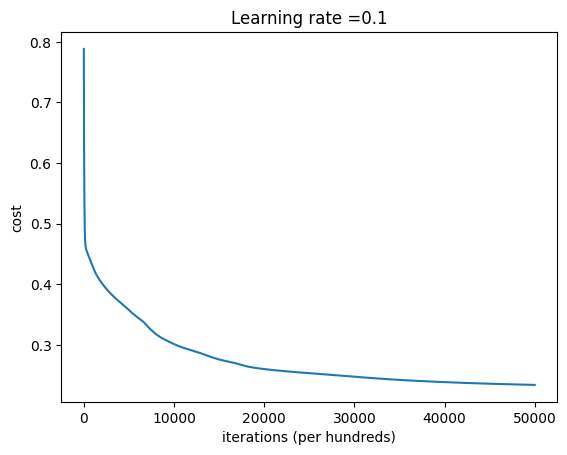

In [ ]:
# Evaluate the network's performance
accuracy_train = accuracy_score_safe(Y_train.T, predictions_train.T) # Transpose back for accuracy_score
accuracy_test = accuracy_score_safe(Y_test.T, predictions_test.T) # Transpose back for accuracy_score

print(f"\nAccuracy on the train set: {accuracy_train:.4f}")
print(f"\nAccuracy on the test set: {accuracy_test:.4f}")

# Optional: Plot the cost
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(learning_rate))
plt.show()

#### L2 Model Performance

Cost after iteration 0: 0.8657006833325085
Cost after iteration 2000: 0.4844148123561369
Cost after iteration 4000: 0.4809520185338852
Cost after iteration 6000: 0.4802137726529809
Cost after iteration 8000: 0.47995368890159085
Cost after iteration 10000: 0.4798622377974801
Cost after iteration 12000: 0.4798146233136229
Cost after iteration 14000: 0.4797836300768174
Cost after iteration 16000: 0.4795195189056336
Cost after iteration 18000: 0.4793669198964611
Cost after iteration 20000: 0.4793415051741322
Cost after iteration 22000: 0.4793239361192522
Cost after iteration 24000: 0.4793092273127859
Cost after iteration 26000: 0.4792983652581671
Cost after iteration 28000: 0.47928980315330705
Cost after iteration 30000: 0.4792857421730399
Cost after iteration 32000: 0.4792785156422191
Cost after iteration 34000: 0.4792741501226792
Cost after iteration 36000: 0.47927132199534983
Cost after iteration 38000: 0.47926637534686345
Cost after iteration 40000: 0.47926470949222605
Cost after itera

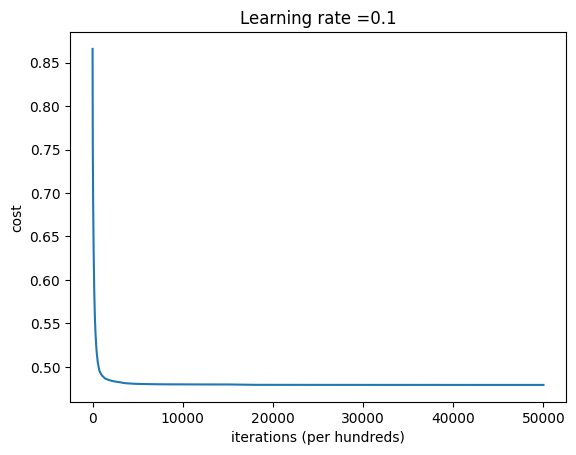

In [ ]:
# Train the neural network
parameters, costs = NN_from_scratch_with_regularization(X_train, Y_train, layers_config, learning_rate, lambd, iter=iterations, activations = 'tanh')

# Make predictions on the test set
A_train, _ = forward_propagation(parameters, X_train)
predictions_train = (A_train > 0.5).astype(int)
A_test, _ = forward_propagation(parameters, X_test)
predictions_test = (A_test > 0.5).astype(int)

# Evaluate the network's performance
accuracy_train = accuracy_score_safe(Y_train.T, predictions_train.T) # Transpose back for accuracy_score
accuracy_test = accuracy_score_safe(Y_test.T, predictions_test.T) # Transpose back for accuracy_score

print(f"\nAccuracy on the train set: {accuracy_train:.4f}")
print(f"\nAccuracy on the test set: {accuracy_test:.4f}")

# Optional: Plot the cost
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(learning_rate))
plt.show()

#### Dropout Model Performance



Cost after iteration 0: 0.6898010143285415
Cost after iteration 2000: 0.5221122289098141
Cost after iteration 4000: 0.4723426210242458
Cost after iteration 6000: 0.5029393936105712
Cost after iteration 8000: 0.491820600086695
Cost after iteration 10000: 0.4856408619382428
Cost after iteration 12000: 0.4936790447090991
Cost after iteration 14000: 0.49094421686288736
Cost after iteration 16000: 0.4812296941328073
Cost after iteration 18000: 0.4625586496795833
Cost after iteration 20000: 0.48918943852355734
Cost after iteration 22000: 0.4927976216059576
Cost after iteration 24000: 0.4787584903622692
Cost after iteration 26000: 0.5097452064930393
Cost after iteration 28000: 0.48418938343591045
Cost after iteration 30000: 0.5083079165896113
Cost after iteration 32000: 0.48893886090983185
Cost after iteration 34000: 0.5010554665171045
Cost after iteration 36000: 0.4879156546025597
Cost after iteration 38000: 0.48796971891561924
Cost after iteration 40000: 0.48483152657493356
Cost after itera

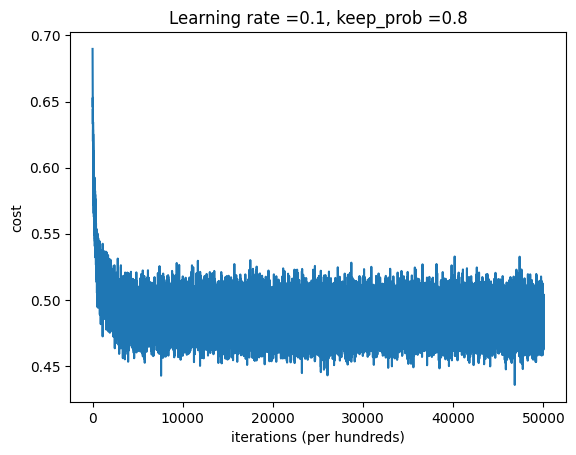


Accuracy on the test set with dropout: 0.7492

Accuracy on the test set with dropout: 0.6558


In [ ]:
iterations = 50000
layers_config = [4, 2]
keep_prob = 0.8 # Probability of keeping a neuron

parameters_dropout, costs_dropout = NN_from_scratch_with_dropout(X_train, Y_train, layers_config, learning_rate, keep_prob, iter=iterations, activations = 'tanh')

# Make predictions on the test set
# Note: Dropout is typically only applied during training.
# For testing, use the standard forward_propagation function.
A_train, _ = forward_propagation(parameters_dropout, X_train)
predictions_train = (A_train > 0.5).astype(int)
A_test, _ = forward_propagation(parameters_dropout, X_test)
predictions_test = (A_test > 0.5).astype(int)


# Evaluate the network's performance
accuracy_train = accuracy_score_safe(Y_train.T, predictions_train.T) # Transpose back for accuracy_score
accuracy_test = accuracy_score_safe(Y_test.T, predictions_test.T) # Transpose back for accuracy_score

# Optional: Plot the cost
plt.plot(costs_dropout)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(learning_rate) + ", keep_prob =" + str(keep_prob))
plt.show()

print(f"\nAccuracy on the test set with dropout: {accuracy_train:.4f}")
print(f"\nAccuracy on the test set with dropout: {accuracy_test:.4f}")

<a name='9-3'></a>
## 9.3 - CIFAR-10 dataset

<a name='9-3-1'></a>
### 9.3.1 - Load and Preprocess Data

In [ ]:
# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

if USE_GPU:
  # NumPy → CuPy
  x_train = np.asarray(x_train)
  y_train = np.asarray(y_train)
  x_test = np.asarray(x_test)
  y_test = np.asarray(y_test)

print(f"X_type = {type(x_train), type(x_test)}")
print(f"Y_type = {type(y_train), type(y_test)}")

# Define the two classes you want to use for binary classification
# For example, let's choose 'cat' (label 3) and 'dog' (label 5)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
class_1_label = 3 # cat
class_2_label = 5 # dog

# Select images and labels belonging to the chosen classes
train_filter = np.where((y_train == class_1_label) | (y_train == class_2_label))[0]
test_filter = np.where((y_test == class_1_label) | (y_test == class_2_label))[0]

x_train_binary, y_train_binary = x_train[train_filter], y_train[train_filter]
x_test_binary, y_test_binary = x_test[test_filter], y_test[test_filter]

# Convert labels to binary (0 for class_1, 1 for class_2)
y_train_binary = np.where(y_train_binary == class_1_label, 0, 1)
y_test_binary = np.where(y_test_binary == class_1_label, 0, 1)

# Print shapes to see the size of the binary dataset
print(f"Original CIFAR-10 train shapes: x={x_train.shape}, y={y_train.shape}")
print(f"Original CIFAR-10 test shapes: x={x_test.shape}, y={y_test.shape}")
print(f"\nBinary train shapes (cat vs dog): x={x_train_binary.shape}, y={y_train_binary.shape}")
print(f"Binary test shapes (cat vs dog): x={x_test_binary.shape}, y={y_test_binary.shape}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
X_type = (<class 'cupy.ndarray'>, <class 'cupy.ndarray'>)
Y_type = (<class 'cupy.ndarray'>, <class 'cupy.ndarray'>)
Original CIFAR-10 train shapes: x=(50000, 32, 32, 3), y=(50000, 1)
Original CIFAR-10 test shapes: x=(10000, 32, 32, 3), y=(10000, 1)

Binary train shapes (cat vs dog): x=(10000, 32, 32, 3), y=(10000, 1)
Binary test shapes (cat vs dog): x=(2000, 32, 32, 3), y=(2000, 1)


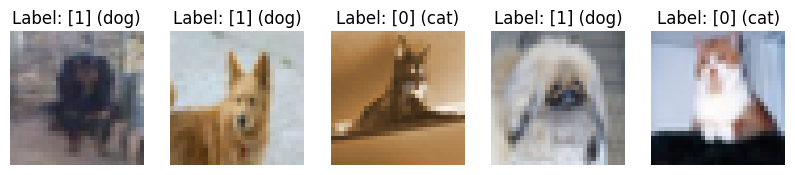

In [ ]:
# Optional: Display a few images from the binary dataset
plt.figure(figsize=(10, 5))
plt_imshow = numpy_safe(plt.imshow)
import random
for k in range(5):
    plt.subplot(1, 5, k + 1)
    i = random.randrange(len(x_train_binary))
    plt_imshow(x_train_binary[i])
    plt.title(f"Label: {y_train_binary[i]} ({class_names[class_1_label] if y_train_binary[i] == 0 else class_names[class_2_label]})")
    plt.axis('off')
plt.show()

In [ ]:
# Preprocess the binary CIFAR-10 data for the neural network
# Flatten the images: (num_examples, height, width, channels) -> (num_examples, height * width * channels)
# And transpose to match the network's expected input shape (input_size, num_examples)
X_train_flat = x_train_binary.reshape(x_train_binary.shape[0], -1).T
X_test_flat = x_test_binary.reshape(x_test_binary.shape[0], -1).T


# Normalize the pixel values to be between 0 and 1
X_train_flat = X_train_flat / 255.0
X_test_flat = X_test_flat / 255.0

# Reshape labels to match the network's expected output shape (output_size, num_examples)
Y_train_reshaped = y_train_binary.reshape(1, -1)
Y_test_reshaped = y_test_binary.reshape(1, -1)


print(f"Flattened and normalized X_train shape: {X_train_flat.shape}")
print(f"Flattened and normalized X_test shape: {X_test_flat.shape}")
print(f"Reshaped Y_train shape: {Y_train_reshaped.shape}")
print(f"Reshaped Y_test shape: {Y_test_reshaped.shape}")

Flattened and normalized X_train shape: (3072, 10000)
Flattened and normalized X_test shape: (3072, 2000)
Reshaped Y_train shape: (1, 10000)
Reshaped Y_test shape: (1, 2000)


In [ ]:
def class_distribution(y):
    unique, counts = np.unique(y, return_counts=True)
    dist = dict(zip(unique.tolist(), counts)) # Convert unique to a list
    df = pd.DataFrame({"Class": unique.get(), "Count": counts.get()}) # Explicitly convert to NumPy
    df["Percentage"] = 100 * df["Count"] / len(y)
    return df

y_train = Y_train_reshaped.flatten()
y_test  = Y_test_reshaped.flatten()

print("Train class distribution:")
print(class_distribution(y_train))

print("\nTest class distribution:")
print(class_distribution(y_test))

Train class distribution:
   Class  Count  Percentage
0      0   5000        50.0
1      1   5000        50.0

Test class distribution:
   Class  Count  Percentage
0      0   1000        50.0
1      1   1000        50.0


<a name='9-3-2'></a>
### 9.3.2 - Model Performance

#### Larger(deep) Model Performance

In [ ]:
# Train the neural network without regularization on the binary CIFAR-10 data

# Define the network architecture
# Using a simple architecture, you might need to tune this
layers_config_cifar = [16, 10, 8, 4, 2]

learning_rate_cifar = 0.01 # You might need to tune this learning rate
iterations_cifar = 100000 # You might need to adjust the number of iterations

num_train_examples_to_keep = 10000 # You can change this number

# Select a subset of the training data
X_train_reduced = X_train_flat[:, :num_train_examples_to_keep]
Y_train_reduced = Y_train_reshaped[:, :num_train_examples_to_keep]

# Train the neural network (using the non-regularized version)
parameters_cifar, costs_cifar = NN_from_scratch(X_train_reduced, Y_train_reduced, layers_config_cifar, learning_rate_cifar, iter=iterations_cifar, activations = 'tanh')


Cost after iteration 0: 0.6952215776015668
Cost after iteration 4000: 0.6335269122954048
Cost after iteration 8000: 0.5934489458177681
Cost after iteration 12000: 0.5550588129940512
Cost after iteration 16000: 0.5188647537567501
Cost after iteration 20000: 0.47828733797752704
Cost after iteration 24000: 0.4647996615033417
Cost after iteration 28000: 0.40693438315397507
Cost after iteration 32000: 0.3657263568962769
Cost after iteration 36000: 0.34171320414636547
Cost after iteration 40000: 0.3354803890285101
Cost after iteration 44000: 0.34220554945806464
Cost after iteration 48000: 0.24912886178011218
Cost after iteration 52000: 0.30780272803918446
Cost after iteration 56000: 0.16231656427677676
Cost after iteration 60000: 0.13484913213872657
Cost after iteration 64000: 0.284196686941682
Cost after iteration 68000: 0.10465363036014323
Cost after iteration 72000: 0.2180424180824302
Cost after iteration 76000: 0.08039247713142018
Cost after iteration 80000: 0.07444116703501898
Cost afte

In [ ]:
# Make predictions on the test set
A_train, _ = forward_propagation(parameters_cifar, X_train_reduced)
predictions_train = (A_train > 0.5).astype(int)
A_test, _ = forward_propagation(parameters_cifar, X_test_flat)
predictions_test = (A_test > 0.5).astype(int)

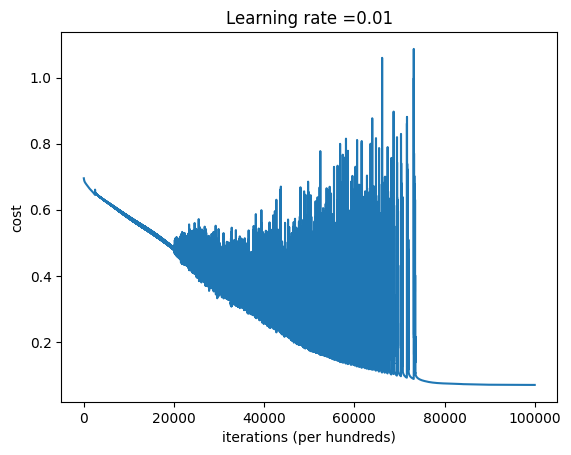


Accuracy on the train set (CIFAR-10 binary): 0.9869

Accuracy on the test set (CIFAR-10 binary): 0.5895


In [ ]:
# Evaluate the network's performance
accuracy_train = accuracy_score_safe(Y_train_reduced.T, predictions_train.T) # Transpose back for accuracy_score
accuracy_test = accuracy_score_safe(Y_test_reshaped.T, predictions_test.T) # Transpose back for accuracy_score

# Optional: Plot the cost
plt.plot(costs_cifar)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(learning_rate_cifar))
plt.show()
print(f"\nAccuracy on the train set (CIFAR-10 binary): {accuracy_train:.4f}")
print(f"\nAccuracy on the test set (CIFAR-10 binary): {accuracy_test:.4f}")

#### Smaller Model Performance

In [ ]:
# Train the neural network without regularization on the binary CIFAR-10 data

# Define the network architecture
# Using a simple architecture, you might need to tune this
layers_config_cifar = [8, 4, 2]

learning_rate_cifar = 0.01 # You might need to tune this learning rate
iterations_cifar = 100000 # You might need to adjust the number of iterations

num_train_examples_to_keep = 10000 # You can change this number

# Select a subset of the training data
X_train_reduced = X_train_flat[:, :num_train_examples_to_keep]
Y_train_reduced = Y_train_reshaped[:, :num_train_examples_to_keep]

# Train the neural network (using the non-regularized version)
parameters_cifar, costs_cifar = NN_from_scratch(X_train_reduced, Y_train_reduced, layers_config_cifar, learning_rate_cifar, iter=iterations_cifar, activations = 'tanh')


Cost after iteration 0: 0.6891542781905937
Cost after iteration 4000: 0.6329794701026694
Cost after iteration 8000: 0.6038870878394951
Cost after iteration 12000: 0.5784619255720335
Cost after iteration 16000: 0.5563571727342609
Cost after iteration 20000: 0.5368069203860086
Cost after iteration 24000: 0.5191381840742015
Cost after iteration 28000: 0.5030499828780017
Cost after iteration 32000: 0.48839466407124893
Cost after iteration 36000: 0.4746877204442318
Cost after iteration 40000: 0.46150046961274577
Cost after iteration 44000: 0.44898623212636696
Cost after iteration 48000: 0.43717714177026723
Cost after iteration 52000: 0.426062931144486
Cost after iteration 56000: 0.4156036306196374
Cost after iteration 60000: 0.4059112770791522
Cost after iteration 64000: 0.39417044371384863
Cost after iteration 68000: 0.41740698608208787
Cost after iteration 72000: 0.35019519069438815
Cost after iteration 76000: 0.3567715942607164
Cost after iteration 80000: 0.3293963017424288
Cost after it

In [ ]:
# Make predictions on the test set
A_train, _ = forward_propagation(parameters_cifar, X_train_reduced)
predictions_train = (A_train > 0.5).astype(int)
A_test, _ = forward_propagation(parameters_cifar, X_test_flat)
predictions_test = (A_test > 0.5).astype(int)

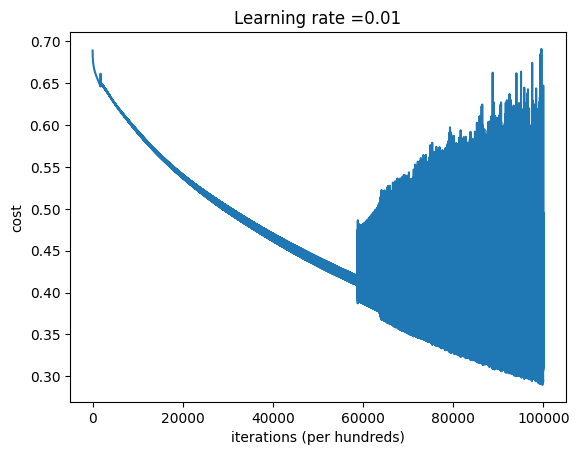


Accuracy on the train set (CIFAR-10 binary): 0.8835

Accuracy on the test set (CIFAR-10 binary): 0.6020


In [ ]:
# Evaluate the network's performance
accuracy_train = accuracy_score_safe(Y_train_reduced.T, predictions_train.T) # Transpose back for accuracy_score
accuracy_test = accuracy_score_safe(Y_test_reshaped.T, predictions_test.T) # Transpose back for accuracy_score

# Optional: Plot the cost
plt.plot(costs_cifar)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(learning_rate_cifar))
plt.show()
print(f"\nAccuracy on the train set (CIFAR-10 binary): {accuracy_train:.4f}")
print(f"\nAccuracy on the test set (CIFAR-10 binary): {accuracy_test:.4f}")

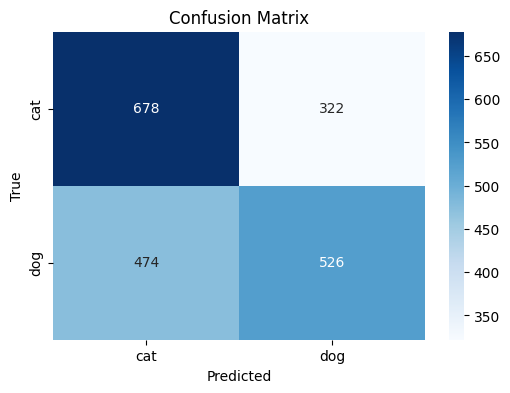

In [ ]:
# Flatten the arrays if they are not already 1D
y_true = Y_test_reshaped.flatten()
y_pred = predictions_test.flatten()

# Compute the confusion matrix
confusion_safe = numpy_safe(confusion_matrix)
cm = confusion_safe(y_true, y_pred)

# Display the confusion matrix using a heatmap for better visualization
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[class_names[class_1_label], class_names[class_2_label]], yticklabels=[class_names[class_1_label], class_names[class_2_label]])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Number of misclassified images: 796


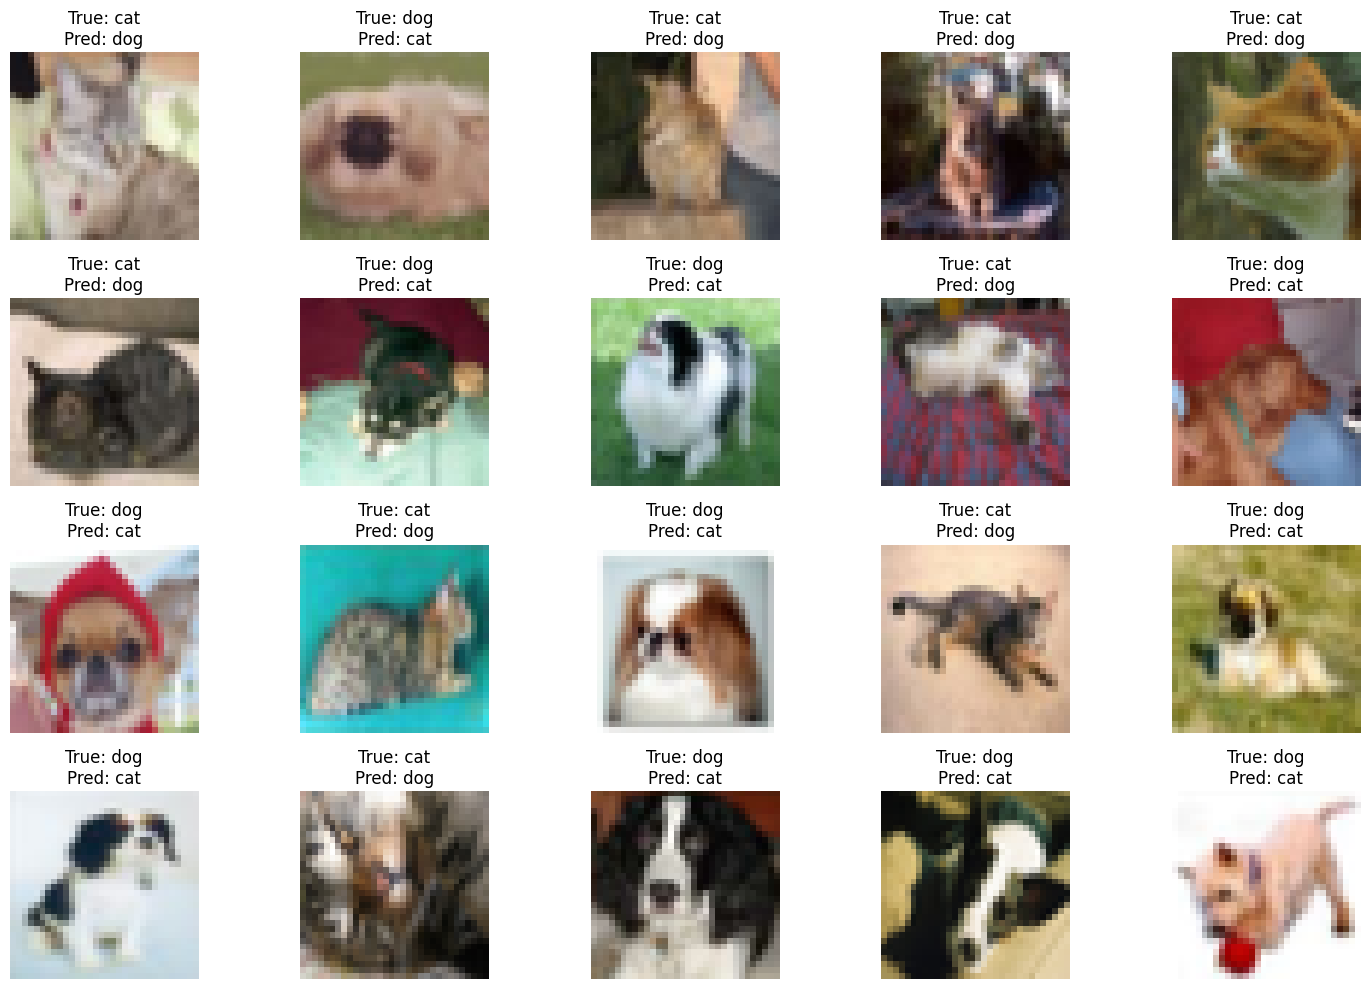

In [ ]:
# Find misclassified images
# Flatten Y_test_reshaped and predictions_test if they are not already 1D
y_true = Y_test_reshaped.flatten()
y_pred = predictions_test.flatten()

# Find the indices where the true labels do not match the predicted labels
misclassified_indices = np.where(y_true != y_pred)[0]

# Print the number of misclassified images
print(f"Number of misclassified images: {len(misclassified_indices)}")

# Plot a few of the misclassified images
plt.figure(figsize=(15, 10))
# Use the numpy_safe decorator for plt.imshow
plt_imshow = numpy_safe(plt.imshow)

num_images_to_plot = min(20, len(misclassified_indices)) # Plot up to 20 misclassified images

for i in range(num_images_to_plot):
    index = misclassified_indices[i]
    plt.subplot(4, 5, i + 1) # Adjust subplot grid based on the number of images
    # Display the original image from the test set
    plt_imshow(x_test_binary[index])
    # Display the true and predicted labels
    true_label = class_names[class_1_label] if y_true[index] == 0 else class_names[class_2_label]
    predicted_label = class_names[class_1_label] if y_pred[index] == 0 else class_names[class_2_label]
    plt.title(f"True: {true_label}\nPred: {predicted_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

#### Smaller Network With More Iteration

In [ ]:
# Train the neural network without regularization on the binary CIFAR-10 data

# Define the network architecture
layers_config_cifar = [8, 4, 2]

learning_rate_cifar = 0.01 # You might need to tune this learning rate
iterations_cifar = 100000 # You might need to adjust the number of iterations

num_train_examples_to_keep = 10000 # You can change this number

# Select a subset of the training data
X_train_reduced = X_train_flat[:, :num_train_examples_to_keep]
Y_train_reduced = Y_train_reshaped[:, :num_train_examples_to_keep]

# Train the neural network (using the non-regularized version)
parameters_cifar, costs_cifar = NN_from_scratch(X_train_reduced, Y_train_reduced, layers_config_cifar, learning_rate_cifar, iter=iterations_cifar, activations = 'tanh',optimizer='momentum')

Cost after iteration 0: 0.6907943336044968
Cost after iteration 4000: 0.6117910645632798
Cost after iteration 8000: 0.5195318251593696
Cost after iteration 12000: 0.46986519287405254
Cost after iteration 16000: 0.4012861054782304
Cost after iteration 20000: 0.37758309395541284
Cost after iteration 24000: 0.31490426850788983
Cost after iteration 28000: 0.2789900376152305
Cost after iteration 32000: 0.2457774220877685
Cost after iteration 36000: 0.29583748520006525
Cost after iteration 40000: 0.2713746493661045
Cost after iteration 44000: 0.16888099278349597
Cost after iteration 48000: 0.1491975022410365
Cost after iteration 52000: 0.13914550304574191
Cost after iteration 56000: 0.13333836176071828
Cost after iteration 60000: 0.1301053926832628
Cost after iteration 64000: 0.12778997877314527
Cost after iteration 68000: 0.12621109756699858
Cost after iteration 72000: 0.12489485439707397
Cost after iteration 76000: 0.1236917023797613
Cost after iteration 80000: 0.1225272606314299
Cost afte

In [ ]:
# Make predictions on the test set
A_train, _ = forward_propagation(parameters_cifar, X_train_reduced)
predictions_train = (A_train > 0.5).astype(int)
A_test, _ = forward_propagation(parameters_cifar, X_test_flat)
predictions_test = (A_test > 0.5).astype(int)

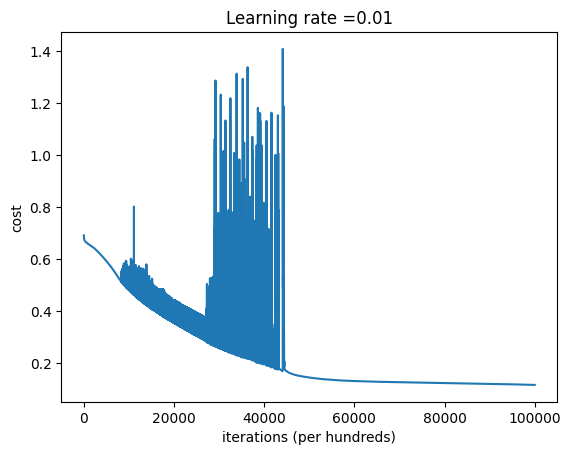


Accuracy on the train set (CIFAR-10 binary): 0.9724

Accuracy on the test set (CIFAR-10 binary): 0.5820


In [ ]:
# Evaluate the network's performance
# accuracy_score_safe = numpy_safe(accuracy_score)
accuracy_train = accuracy_score_safe(Y_train_reduced.T, predictions_train.T) # Transpose back for accuracy_score
accuracy_test = accuracy_score_safe(Y_test_reshaped.T, predictions_test.T) # Transpose back for accuracy_score

# Optional: Plot the cost
plt.plot(costs_cifar)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(learning_rate_cifar))
plt.show()
print(f"\nAccuracy on the train set (CIFAR-10 binary): {accuracy_train:.4f}")
print(f"\nAccuracy on the test set (CIFAR-10 binary): {accuracy_test:.4f}")

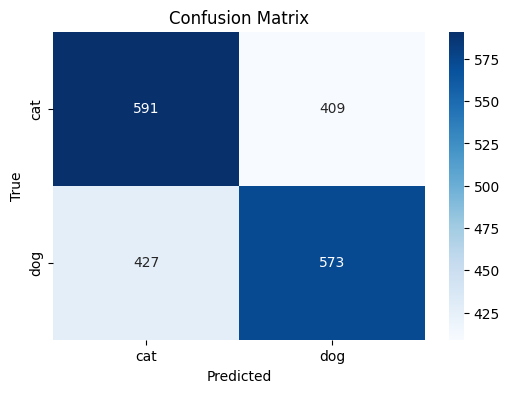

In [ ]:
# Assuming Y_test_reshaped and predictions_test are available from previous cells
# and are in the correct format (e.g., 1D arrays or flattened).

# Flatten the arrays if they are not already 1D
y_true = Y_test_reshaped.flatten()
y_pred = predictions_test.flatten()

# Compute the confusion matrix
confusion_safe = numpy_safe(confusion_matrix)
cm = confusion_safe(y_true, y_pred)

# Display the confusion matrix using a heatmap for better visualization
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[class_names[class_1_label], class_names[class_2_label]], yticklabels=[class_names[class_1_label], class_names[class_2_label]])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Number of misclassified images: 836


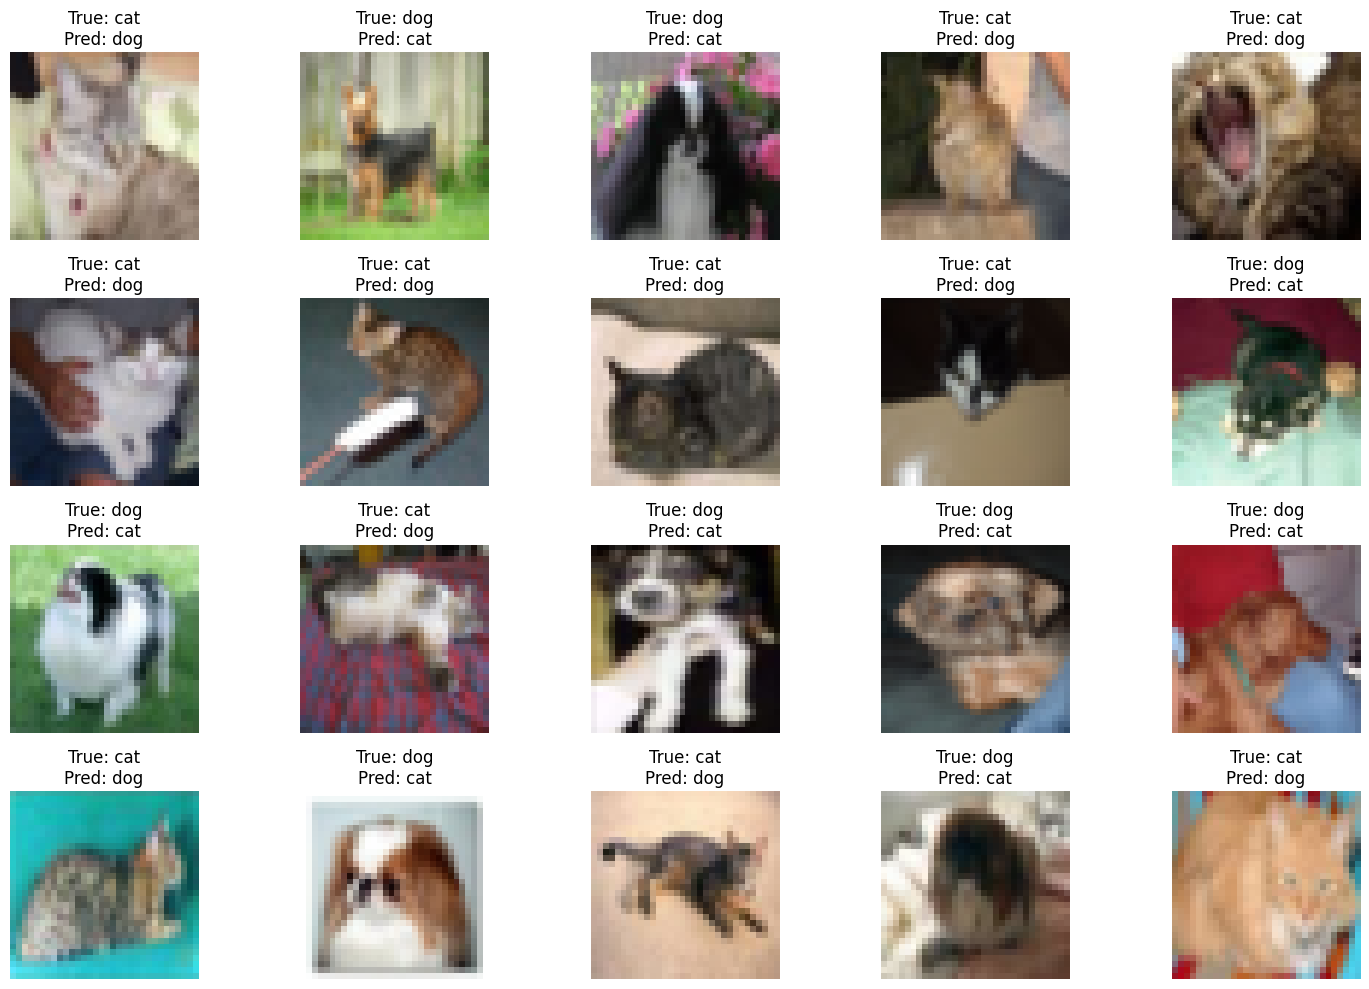

In [ ]:
# Find misclassified images
# Flatten Y_test_reshaped and predictions_test if they are not already 1D
y_true = Y_test_reshaped.flatten()
y_pred = predictions_test.flatten()

# Find the indices where the true labels do not match the predicted labels
misclassified_indices = np.where(y_true != y_pred)[0]

# Print the number of misclassified images
print(f"Number of misclassified images: {len(misclassified_indices)}")

# Plot a few of the misclassified images
plt.figure(figsize=(15, 10))
# Use the numpy_safe decorator for plt.imshow
plt_imshow = numpy_safe(plt.imshow)

num_images_to_plot = min(20, len(misclassified_indices)) # Plot up to 20 misclassified images

for i in range(num_images_to_plot):
    index = misclassified_indices[i]
    plt.subplot(4, 5, i + 1) # Adjust subplot grid based on the number of images
    # Display the original image from the test set
    plt_imshow(x_test_binary[index])
    # Display the true and predicted labels
    true_label = class_names[class_1_label] if y_true[index] == 0 else class_names[class_2_label]
    predicted_label = class_names[class_1_label] if y_pred[index] == 0 else class_names[class_2_label]
    plt.title(f"True: {true_label}\nPred: {predicted_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

#### L2 Regularised Model Performance

In [ ]:
# Train the neural network without regularization on the binary CIFAR-10 data

# Define the network architecture
# Using a simple architecture, you might need to tune this
layers_config_cifar = [8, 4, 2]
lambd = 1e-3
learning_rate_cifar = 0.01 # Further reduced learning rate
iterations_cifar = 50000 # You might need to adjust the number of iterations

num_train_examples_to_keep = 10000 # You can change this number

# Select a subset of the training data
X_train_reduced = X_train_flat[:, :num_train_examples_to_keep]
Y_train_reduced = Y_train_reshaped[:, :num_train_examples_to_keep]

# Train the neural network (using the L2-regularized version)
parameters_cifar, costs_cifar = NN_from_scratch_with_regularization(X_train_reduced, Y_train_reduced, layers_config_cifar, learning_rate_cifar,lambd, iter=iterations_cifar, activations = 'tanh', optimizer = 'momentum')

Cost after iteration 0: 0.692605904426744
Cost after iteration 2000: 0.6662372709417141
Cost after iteration 4000: 0.6475602102183896
Cost after iteration 6000: 0.6197992995108026
Cost after iteration 8000: 0.5850588175884925
Cost after iteration 10000: 0.5413710068554882
Cost after iteration 12000: 0.5308944096959293
Cost after iteration 14000: 0.46239226147368984
Cost after iteration 16000: 0.4385715816936949
Cost after iteration 18000: 0.4441761185605605
Cost after iteration 20000: 0.43218980912155086
Cost after iteration 22000: 0.41269144606072977
Cost after iteration 24000: 0.33754083021572484
Cost after iteration 26000: 0.3657985633719434
Cost after iteration 28000: 0.33958001671711313
Cost after iteration 30000: 0.24618393876260072
Cost after iteration 32000: 0.28214460034019934
Cost after iteration 34000: 0.20426637528597252
Cost after iteration 36000: 0.190175971281965
Cost after iteration 38000: 0.18431202776097594
Cost after iteration 40000: 0.1705446029611076
Cost after ite

In [ ]:
# Make predictions on the test set
A_train, _ = forward_propagation(parameters_cifar, X_train_reduced)
predictions_train = (A_train > 0.5).astype(int)
A_test, _ = forward_propagation(parameters_cifar, X_test_flat)
predictions_test = (A_test > 0.5).astype(int)

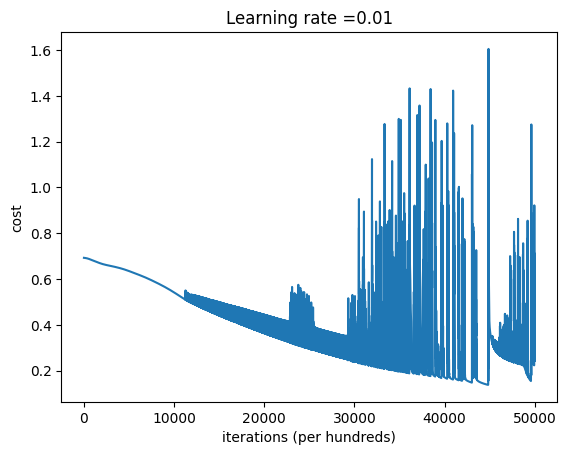


Accuracy on the train set (CIFAR-10 binary): 0.7788

Accuracy on the test set (CIFAR-10 binary): 0.6010


In [ ]:
# Evaluate the network's performance
# accuracy_score_safe = numpy_safe(accuracy_score)
accuracy_train = accuracy_score_safe(Y_train_reduced.T, predictions_train.T) # Transpose back for accuracy_score
accuracy_test = accuracy_score_safe(Y_test_reshaped.T, predictions_test.T) # Transpose back for accuracy_score

# Optional: Plot the cost
plt.plot(costs_cifar)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(learning_rate_cifar))
plt.show()
print(f"\nAccuracy on the train set (CIFAR-10 binary): {accuracy_train:.4f}")
print(f"\nAccuracy on the test set (CIFAR-10 binary): {accuracy_test:.4f}")

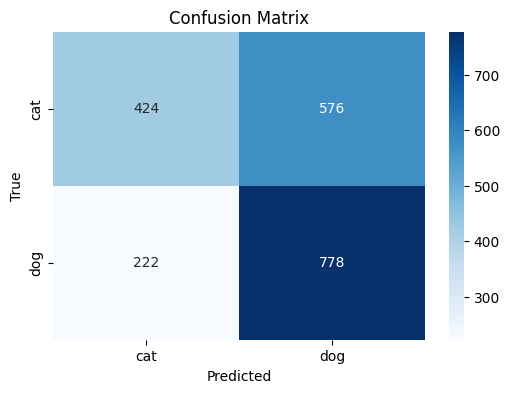

In [ ]:
# Assuming Y_test_reshaped and predictions_test are available from previous cells
# and are in the correct format (e.g., 1D arrays or flattened).

# Flatten the arrays if they are not already 1D
y_true = Y_test_reshaped.flatten()
y_pred = predictions_test.flatten()

# Compute the confusion matrix
confusion_safe = numpy_safe(confusion_matrix)
cm = confusion_safe(y_true, y_pred)

# Display the confusion matrix using a heatmap for better visualization
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[class_names[class_1_label], class_names[class_2_label]], yticklabels=[class_names[class_1_label], class_names[class_2_label]])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#### Dropout Model Performance

In [ ]:
# Train the neural network without regularization on the binary CIFAR-10 data

# Define the network architecture
# Using a simple architecture, you might need to tune this
layers_config_cifar = [8, 4]
keep_prob = 0.8
learning_rate_cifar = 0.01 # You might need to tune this learning rate
iterations_cifar = 150000 # You might need to adjust the number of iterations

num_train_examples_to_keep = 10000 # You can change this number

# Select a subset of the training data
X_train_reduced = X_train_flat[:, :num_train_examples_to_keep]
Y_train_reduced = Y_train_reshaped[:, :num_train_examples_to_keep]

# Train the neural network (using the Dropout regularized version)
parameters_cifar, costs_dropout = NN_from_scratch_with_dropout(X_train_reduced, Y_train_reduced, layers_config_cifar, learning_rate_cifar, keep_prob, iter=iterations_cifar, activations = 'tanh', optimizer = 'momentum')

Cost after iteration 0: 0.6959215964615464
Cost after iteration 6000: 0.6364679803701017
Cost after iteration 12000: 0.6155803497768372
Cost after iteration 18000: 0.5981574218273354
Cost after iteration 24000: 0.5889600489996758
Cost after iteration 30000: 0.5766546617568665
Cost after iteration 36000: 0.5755749685615187
Cost after iteration 42000: 0.5687930277647641
Cost after iteration 48000: 0.5645360472964726
Cost after iteration 54000: 0.5626153795181342
Cost after iteration 60000: 0.5645058769463438
Cost after iteration 66000: 0.5540051316791016
Cost after iteration 72000: 0.5573967325386853


In [ ]:
# Make predictions on the test set
A_train, _ = forward_propagation(parameters_cifar, X_train_reduced)
predictions_train = (A_train > 0.5).astype(int)
A_test, _ = forward_propagation(parameters_cifar, X_test_flat)
predictions_test = (A_test > 0.5).astype(int)

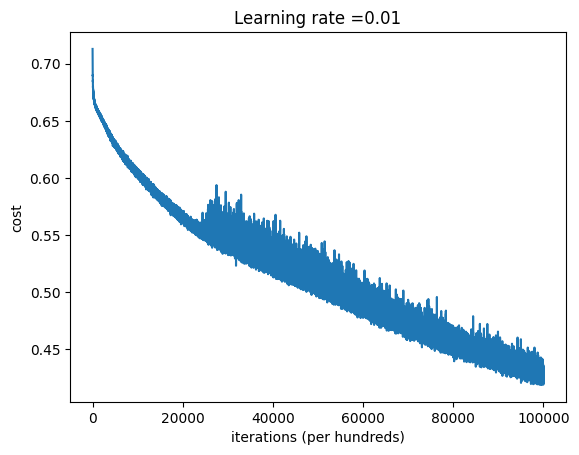


Accuracy on the train set (CIFAR-10 binary): 0.8539

Accuracy on the test set (CIFAR-10 binary): 0.6025


In [ ]:
# Evaluate the network's performance
accuracy_train = accuracy_score_safe(Y_train_reduced.T, predictions_train.T) # Transpose back for accuracy_score
accuracy_test = accuracy_score_safe(Y_test_reshaped.T, predictions_test.T) # Transpose back for accuracy_score

# Optional: Plot the cost
plt.plot(costs_dropout)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(learning_rate_cifar))
plt.show()
print(f"\nAccuracy on the train set (CIFAR-10 binary): {accuracy_train:.4f}")
print(f"\nAccuracy on the test set (CIFAR-10 binary): {accuracy_test:.4f}")

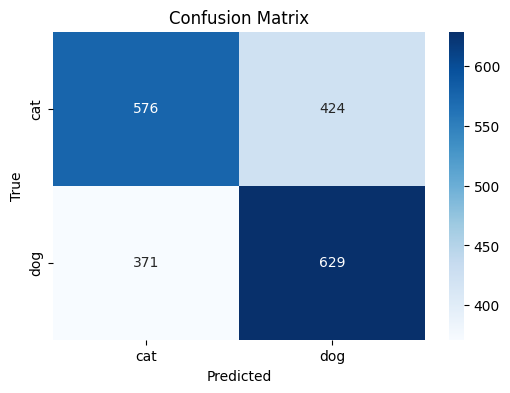

In [ ]:
# Assuming Y_test_reshaped and predictions_test are available from previous cells
# and are in the correct format (e.g., 1D arrays or flattened).

# Flatten the arrays if they are not already 1D
y_true = Y_test_reshaped.flatten()
y_pred = predictions_test.flatten()

# Compute the confusion matrix
confusion_safe = numpy_safe(confusion_matrix)
cm = confusion_safe(y_true, y_pred)

# Display the confusion matrix using a heatmap for better visualization
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[class_names[class_1_label], class_names[class_2_label]], yticklabels=[class_names[class_1_label], class_names[class_2_label]])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Conclusion

## Results

This notebook explored the implementation of a simple Multi-Layer Perceptron (MLP) neural network from scratch, including the application of L2 regularization and Dropout as techniques to mitigate overfitting. The models were trained and evaluated on three datasets: the Pima Indians Diabetes dataset (a smaller tabular dataset) , breast cancer dataset and a binary subset of the CIFAR-10 dataset (image data).

The table below summarizes the performance of the different models based on their accuracy on the test sets:

| Dataset                   | Model Type                       | Train Accuracy   | Test Accuracy   |
|-------------------------|--------------------------------|----------------|---------------|
| Breast Cancer            | Basic NN (tanh)                  | 0.9978         | 0.9649        |
| Pima Indians Diabetes    | Basic NN (tanh)                  | 0.9055         | 0.7208        |
| Pima Indians Diabetes    | L2 Regularized NN (tanh)         | 0.7573         | 0.7597        |
| CIFAR-10 (Cat vs Dog)    | Basic NN (Larger, tanh)          | 0.9869         | 0.5895        |
| CIFAR-10 (Cat vs Dog)    | Basic NN (Smaller, tanh)         | 0.8835         | 0.6020        |
| CIFAR-10 (Cat vs Dog)    | L2 Regularized NN (Smaller)      | 0.7788         | 0.6010        |
| CIFAR-10 (Cat vs Dog)    | Dropout Regularized NN (Smaller) | 0.8539         | 0.6025        |


**Observations:**

*   On the **Breast Cancer** dataset, the basic neural network achieved high accuracy on both the training and test sets.
*   On the **Pima Indians Diabetes** dataset, L2 regularization showed a slight improvement in test accuracy compared to the basic model, suggesting it helped in generalization.
*   On the **CIFAR-10 binary** dataset, the models generally showed a significant gap between training and test accuracy, indicating overfitting, especially with the larger network. The smaller networks attempted to reduce this gap. Regularization techniques (L2 and Dropout)  did not lead to substantial improvements in test accuracy in these experiments, with the test accuracy remaining around 60%.